Import all dependancies

In [24]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

# TODO: Handle relative paths correctly so we can all run it independantly and add to the readme where the dataset needs to be stored
dataset_path = r"C:\Users\chris\Desktop\University\Code\ComputerVision\ForestNetDataset"

Load the dataset into memory

In [27]:
# Join the directory with each CSV filename.
test_path = os.path.join(dataset_path, "test.csv")
train_path = os.path.join(dataset_path, "train.csv")
validation_path = os.path.join(dataset_path, "val.csv")

# Read the CSV files into pandas DataFrames.
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(validation_path)

# Create a mapping from the string labels to integers based on the training data.
labels = sorted(train_df["merged_label"].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}
print("Label mapping:", label_to_index)


# FOR MODEL DEVELOPMENT JUST USE THE FIRST 128 SAMPLES FROM THE TRAINING SET
# train_df = train_df.head(128)

Label mapping: {'Grassland shrubland': 0, 'Other': 1, 'Plantation': 2, 'Smallholder agriculture': 3}


Balance the training set

In [32]:
# Print counts per class before oversampling
print("Counts per class before oversampling:")
print(train_df["merged_label"].value_counts())

# Get the maximum count among classes
max_count = train_df["merged_label"].value_counts().max()

# For each class, sample max_count examples with replacement.
balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(
    lambda x: x.sample(max_count, replace=True, random_state=42)
).reset_index(drop=True)

print("After oversampling, counts per class:")
print(balanced_train_df["merged_label"].value_counts())
train_df = balanced_train_df

Counts per class before oversampling:
merged_label
Plantation                 686
Smallholder agriculture    556
Other                      231
Grassland shrubland        143
Name: count, dtype: int64
After oversampling, counts per class:
merged_label
Grassland shrubland        686
Other                      686
Plantation                 686
Smallholder agriculture    686
Name: count, dtype: int64


C:\Users\chris\AppData\Local\Temp\ipykernel_4076\1046957484.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(


Define DataLoaders for the training and test set

In [33]:

# This class implements the function __getitem__ which means it can be passed into the DataLoader class from pytorch 
# which makes the batch processing much more seamless.
class ForestNetDataset(Dataset):
    def __init__(self, df, dataset_path, transform=None, label_map=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing the image paths and labels.
            dataset_path (str): The base directory for the images.
            transform (callable, optional): A function/transform to apply to the images.
            label_map (dict, optional): Mapping from label names to integers.
        """
        self.df = df
        self.dataset_path = dataset_path
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            image_rel_path = row["example_path"] + "/images/visible/composite.png"
            image_path = os.path.join(self.dataset_path, image_rel_path)
            # Debug: print the image_path to see if it looks correct
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = row["merged_label"]
            if self.label_map is not None:
                label = self.label_map[label]
            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx} from path {image_path}: {e}")
            raise e


# --- Image Transforms ---
# Resize images to 224x224, convert them to tensors, and normalize.
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),

    # TODO: Look into calculating these values for our dataset. It probably has a lot more green than other
    # datasets.
    # These normalization values are typical for natural images.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Create Datasets and DataLoaders ---
train_dataset = ForestNetDataset(train_df, dataset_path, transform=transform, label_map=label_to_index)
test_dataset = ForestNetDataset(test_df, dataset_path, transform=transform, label_map=label_to_index)


batch_size = 32
# TO DO: Experiment with different num_workers (I don't know what this does)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Train and evaluate model

In [ ]:

# Define a CNN with input images sized 256x256
# TO DO: Define a different CNN archtecture for different image sizes eg. 512 and 1024
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1: Input 3 x 256 x 256 -> Output 16 x 256 x 256, then maxpool to 16 x 128 x 128
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 2: 16 x 128 x 128 -> 32 x 128 x 128, then maxpool to 32 x 64 x 64
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 3: 32 x 64 x 64 -> 64 x 64 x 64, then maxpool to 64 x 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features for the classifier
        x = self.classifier(x)
        return x

# Assume the number of classes is determined by your label mapping:
num_classes = len(label_to_index)
model = SimpleCNN(num_classes)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and Evaluation Loop
num_epochs = 60
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    epoch_start = time.time()  # Start time for the epoch
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()           # Zero the gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    # --- Evaluation ---
    model.eval()
    correct = 0
    total = 0

    # UNCOMMENT IF YOU WANT TO EVALUATE THE TEST ACCURACY EVERY EPOCH
    # with torch.no_grad():
    #     for images, labels in test_loader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, preds = torch.max(outputs, 1)
    #         correct += (preds == labels).sum().item()
    #         total += labels.size(0)
    # accuracy = correct / total
    # print(f"Test Accuracy: {accuracy:.4f}")

    epoch_end = time.time()  # End time for the epoch
    epoch_duration = epoch_end - epoch_start
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_time_remaining = epoch_duration * remaining_epochs
    print(f"Epoch Time: {epoch_duration:.2f}s, Estimated time remaining: {estimated_time_remaining:.2f}s\n")

print("Training complete.")


Using device: cuda
Epoch 1/30, Loss: 1.3871
Epoch Time: 33.52s, Estimated time remaining: 972.16s

Epoch 2/30, Loss: 1.3514
Epoch Time: 29.61s, Estimated time remaining: 829.12s

Epoch 3/30, Loss: 1.3153
Epoch Time: 26.13s, Estimated time remaining: 705.44s

Epoch 4/30, Loss: 1.2586
Epoch Time: 26.74s, Estimated time remaining: 695.13s

Epoch 5/30, Loss: 1.1997
Epoch Time: 35.49s, Estimated time remaining: 887.17s

Epoch 6/30, Loss: 1.1481
Epoch Time: 30.23s, Estimated time remaining: 725.57s

Epoch 7/30, Loss: 1.0993
Epoch Time: 29.18s, Estimated time remaining: 671.22s

Epoch 8/30, Loss: 1.0325
Epoch Time: 28.41s, Estimated time remaining: 624.95s

Epoch 9/30, Loss: 0.9666
Epoch Time: 29.65s, Estimated time remaining: 622.69s

Epoch 10/30, Loss: 0.9208
Epoch Time: 30.21s, Estimated time remaining: 604.10s

Epoch 11/30, Loss: 0.8585
Epoch Time: 30.18s, Estimated time remaining: 573.34s

Epoch 12/30, Loss: 0.7985
Epoch Time: 31.69s, Estimated time remaining: 570.34s

Epoch 13/30, Loss:

Classification Report:
                         precision    recall  f1-score   support

    Grassland shrubland     0.2400    0.2338    0.2368        77
                  Other     0.2570    0.4340    0.3228       106
             Plantation     0.4729    0.4535    0.4630       269
Smallholder agriculture     0.4679    0.3380    0.3925       216

               accuracy                         0.3877       668
              macro avg     0.3595    0.3648    0.3538       668
           weighted avg     0.4102    0.3877    0.3919       668



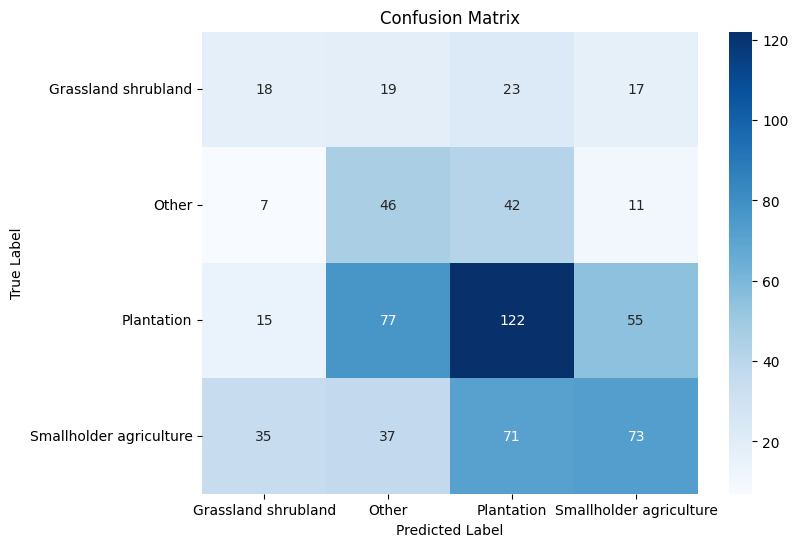

In [37]:
# Create a mapping to convert indices back to labels (for display purposes)
index_to_label = {v: k for k, v in label_to_index.items()}
target_names = [index_to_label[i] for i in range(num_classes)]

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report (includes precision, recall, and F1 score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Print confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap to display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()